In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.combine import SMOTETomek

In [43]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

print(train_df.head())

train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

print(f"\nTraining data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      long city_pop                          job  \
0  ...  62220  38.5127  -89.9847    

In [44]:
train_df['trans_datetime'] = pd.to_datetime(train_df['trans_date'] + ' ' + train_df['trans_time'])
test_df['trans_datetime'] = pd.to_datetime(test_df['trans_date'] + ' ' + test_df['trans_time'])

for df in [train_df, test_df]:
    df['transaction_hour'] = df['trans_datetime'].dt.hour
    df['transaction_day'] = df['trans_datetime'].dt.day
    df['transaction_month'] = df['trans_datetime'].dt.month
    df['transaction_year'] = df['trans_datetime'].dt.year
    df['transaction_dayofweek'] = df['trans_datetime'].dt.dayofweek

train_df['dob'] = pd.to_datetime(train_df['dob'])
test_df['dob'] = pd.to_datetime(test_df['dob'])
train_df['age'] = (train_df['trans_datetime'] - train_df['dob']).dt.days / 365
test_df['age'] = (test_df['trans_datetime'] - test_df['dob']).dt.days / 365

high_risk_categories = train_df.groupby('category')['is_fraud'].mean()
train_df['category_risk'] = train_df['category'].map(high_risk_categories)
test_df['category_risk'] = test_df['category'].map(high_risk_categories).fillna(0)

train_df['is_weekend'] = train_df['transaction_dayofweek'].isin([5, 6]).astype(int)
test_df['is_weekend'] = test_df['transaction_dayofweek'].isin([5, 6]).astype(int)

train_df['fraud_count_per_cc'] = train_df.groupby('cc_num')['is_fraud'].cumsum()
test_df['fraud_count_per_cc'] = test_df.groupby('cc_num')['is_fraud'].cumsum()

train_df['prev_trans_time'] = train_df.groupby('cc_num')['unix_time'].shift(1)
train_df['time_since_last_trans'] = train_df['unix_time'] - train_df['prev_trans_time']
train_df['time_since_last_trans'].fillna(train_df['time_since_last_trans'].mean(), inplace=True)

rolling_stats = train_df.groupby('cc_num')['amt'].rolling(window=3, min_periods=1).agg(['mean', 'std']).reset_index()
rolling_stats.rename(columns={'level_1': 'rolling_idx'}, inplace=True) 
rolling_stats.columns = ['cc_num', 'rolling_idx', 'amt_mean_3', 'amt_std_3'] 

train_df = train_df.reset_index(drop=True)
rolling_stats['rolling_idx'] = rolling_stats['rolling_idx'].astype(int) 
train_df['rolling_idx'] = train_df.index 

train_df = train_df.merge(rolling_stats, on=['cc_num', 'rolling_idx'], how='left')

rolling_stats_test = test_df.groupby('cc_num')['amt'].rolling(window=3, min_periods=1).agg(['mean', 'std']).reset_index()
rolling_stats_test.rename(columns={'level_1': 'rolling_idx'}, inplace=True)
rolling_stats_test.columns = ['cc_num', 'rolling_idx', 'amt_mean_3', 'amt_std_3']

test_df = test_df.reset_index(drop=True)
rolling_stats_test['rolling_idx'] = rolling_stats_test['rolling_idx'].astype(int)
test_df['rolling_idx'] = test_df.index

test_df = test_df.merge(rolling_stats_test, on=['cc_num', 'rolling_idx'], how='left')

test_df['prev_trans_time'] = test_df.groupby('cc_num')['unix_time'].shift(1)
test_df['time_since_last_trans'] = test_df['unix_time'] - test_df['prev_trans_time']
test_df['time_since_last_trans'].fillna(train_df['time_since_last_trans'].mean(), inplace=True)

merchant_popularity = train_df['merchant'].value_counts()
train_df['merchant_popularity'] = train_df['merchant'].map(merchant_popularity)
test_df['merchant_popularity'] = test_df['merchant'].map(merchant_popularity).fillna(0)


le = LabelEncoder()

train_df['age_bucket'] = pd.cut(train_df['age'], bins=[0, 20, 40, 60, 100], labels=['<20', '20-40', '40-60', '>60'])
test_df['age_bucket'] = pd.cut(test_df['age'], bins=[0, 20, 40, 60, 100], labels=['<20', '20-40', '40-60', '>60'])

train_df['pop_density_risk'] = pd.cut(train_df['city_pop'], bins=[0, 1000, 10000, 100000, 1000000],
                                      labels=['Rural', 'Suburban', 'Urban', 'Metropolitan'])
test_df['pop_density_risk'] = pd.cut(test_df['city_pop'], bins=[0, 1000, 10000, 100000, 1000000],
                                     labels=['Rural', 'Suburban', 'Urban', 'Metropolitan'])

job_fraud_rate = train_df.groupby('job')['is_fraud'].mean().sort_values(ascending=False)

train_df['job_risk_score'] = train_df['job'].map(job_fraud_rate)
test_df['job_risk_score'] = test_df['job'].map(job_fraud_rate)

test_df['job_risk_score'] = test_df['job_risk_score'].fillna(0)

city_fraud_rate = train_df.groupby('city')['is_fraud'].mean()
state_fraud_rate = train_df.groupby('state')['is_fraud'].mean()
zip_fraud_rate = train_df.groupby('zip')['is_fraud'].mean()

train_df['city_risk_score'] = train_df['city'].map(city_fraud_rate)
train_df['state_risk_score'] = train_df['state'].map(state_fraud_rate)
train_df['zip_risk_score'] = train_df['zip'].map(zip_fraud_rate)

test_df['city_risk_score'] = test_df['city'].map(city_fraud_rate).fillna(0)
test_df['state_risk_score'] = test_df['state'].map(state_fraud_rate).fillna(0)
test_df['zip_risk_score'] = test_df['zip'].map(zip_fraud_rate).fillna(0)

top_cities = train_df['city'].value_counts().head(10).index
top_states = train_df['state'].value_counts().head(10).index

train_df['top_city'] = train_df['city'].apply(lambda x: 1 if x in top_cities else 0)
train_df['top_state'] = train_df['state'].apply(lambda x: 1 if x in top_states else 0)

test_df['top_city'] = test_df['city'].apply(lambda x: 1 if x in top_cities else 0)
test_df['top_state'] = test_df['state'].apply(lambda x: 1 if x in top_states else 0)

train_df['zip_prefix'] = train_df['zip'].astype(str).str[:3]
test_df['zip_prefix'] = test_df['zip'].astype(str).str[:3]

zip_prefix_fraud_rate = train_df.groupby('zip_prefix')['is_fraud'].mean()
train_df['zip_prefix_risk_score'] = train_df['zip_prefix'].map(zip_prefix_fraud_rate)
test_df['zip_prefix_risk_score'] = test_df['zip_prefix'].map(zip_prefix_fraud_rate).fillna(0)

merchant_fraud_rate = train_df.groupby('merchant')['is_fraud'].mean()

train_df['merchant_risk_score'] = train_df['merchant'].map(merchant_fraud_rate)
test_df['merchant_risk_score'] = test_df['merchant'].map(merchant_fraud_rate)

test_df['merchant_risk_score'] = test_df['merchant_risk_score'].fillna(0)

merchant_transaction_count = train_df['merchant'].value_counts()

train_df['merchant_transaction_count'] = train_df['merchant'].map(merchant_transaction_count)
test_df['merchant_transaction_count'] = test_df['merchant'].map(merchant_transaction_count).fillna(0)

top_risky_merchants = merchant_fraud_rate.sort_values(ascending=False).head(10).index

train_df['is_top_risky_merchant'] = train_df['merchant'].apply(lambda x: 1 if x in top_risky_merchants else 0)
test_df['is_top_risky_merchant'] = test_df['merchant'].apply(lambda x: 1 if x in top_risky_merchants else 0)

transaction_count = train_df['cc_num'].value_counts()

train_df['cc_transaction_count'] = train_df['cc_num'].map(transaction_count)
test_df['cc_transaction_count'] = test_df['cc_num'].map(transaction_count).fillna(0)

fraud_count = train_df[train_df['is_fraud'] == 1].groupby('cc_num').size()
fraud_rate = fraud_count / transaction_count

train_df['cc_fraud_count'] = train_df['cc_num'].map(fraud_count).fillna(0)
train_df['cc_fraud_rate'] = train_df['cc_num'].map(fraud_rate).fillna(0)

test_df['cc_fraud_count'] = test_df['cc_num'].map(fraud_count).fillna(0)
test_df['cc_fraud_rate'] = test_df['cc_num'].map(fraud_rate).fillna(0)

avg_transaction_amt = train_df.groupby('cc_num')['amt'].mean()

train_df['cc_avg_transaction_amt'] = train_df['cc_num'].map(avg_transaction_amt)
test_df['cc_avg_transaction_amt'] = test_df['cc_num'].map(avg_transaction_amt).fillna(train_df['amt'].mean())

train_df = train_df.sort_values(['cc_num', 'unix_time'])
train_df['cc_time_since_last_trans'] = train_df.groupby('cc_num')['unix_time'].diff().fillna(0)

test_df = test_df.sort_values(['cc_num', 'unix_time'])
test_df['cc_time_since_last_trans'] = test_df.groupby('cc_num')['unix_time'].diff().fillna(0)

high_risk_threshold = 0.2  
train_df['is_high_risk_card'] = (train_df['cc_fraud_rate'] > high_risk_threshold).astype(int)
test_df['is_high_risk_card'] = (test_df['cc_fraud_rate'] > high_risk_threshold).astype(int)

categorical_columns = ['pop_density_risk', 'category', 'state', 'age_bucket']

train_df = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_columns, drop_first=True)

C:\Users\jason\AppData\Local\Temp\ipykernel_11972\3525466386.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['time_since_last_trans'].fillna(train_df['time_since_last_trans'].mean(), inplace=True)
C:\Users\jason\AppData\Local\Temp\ipykernel_11972\3525466386.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

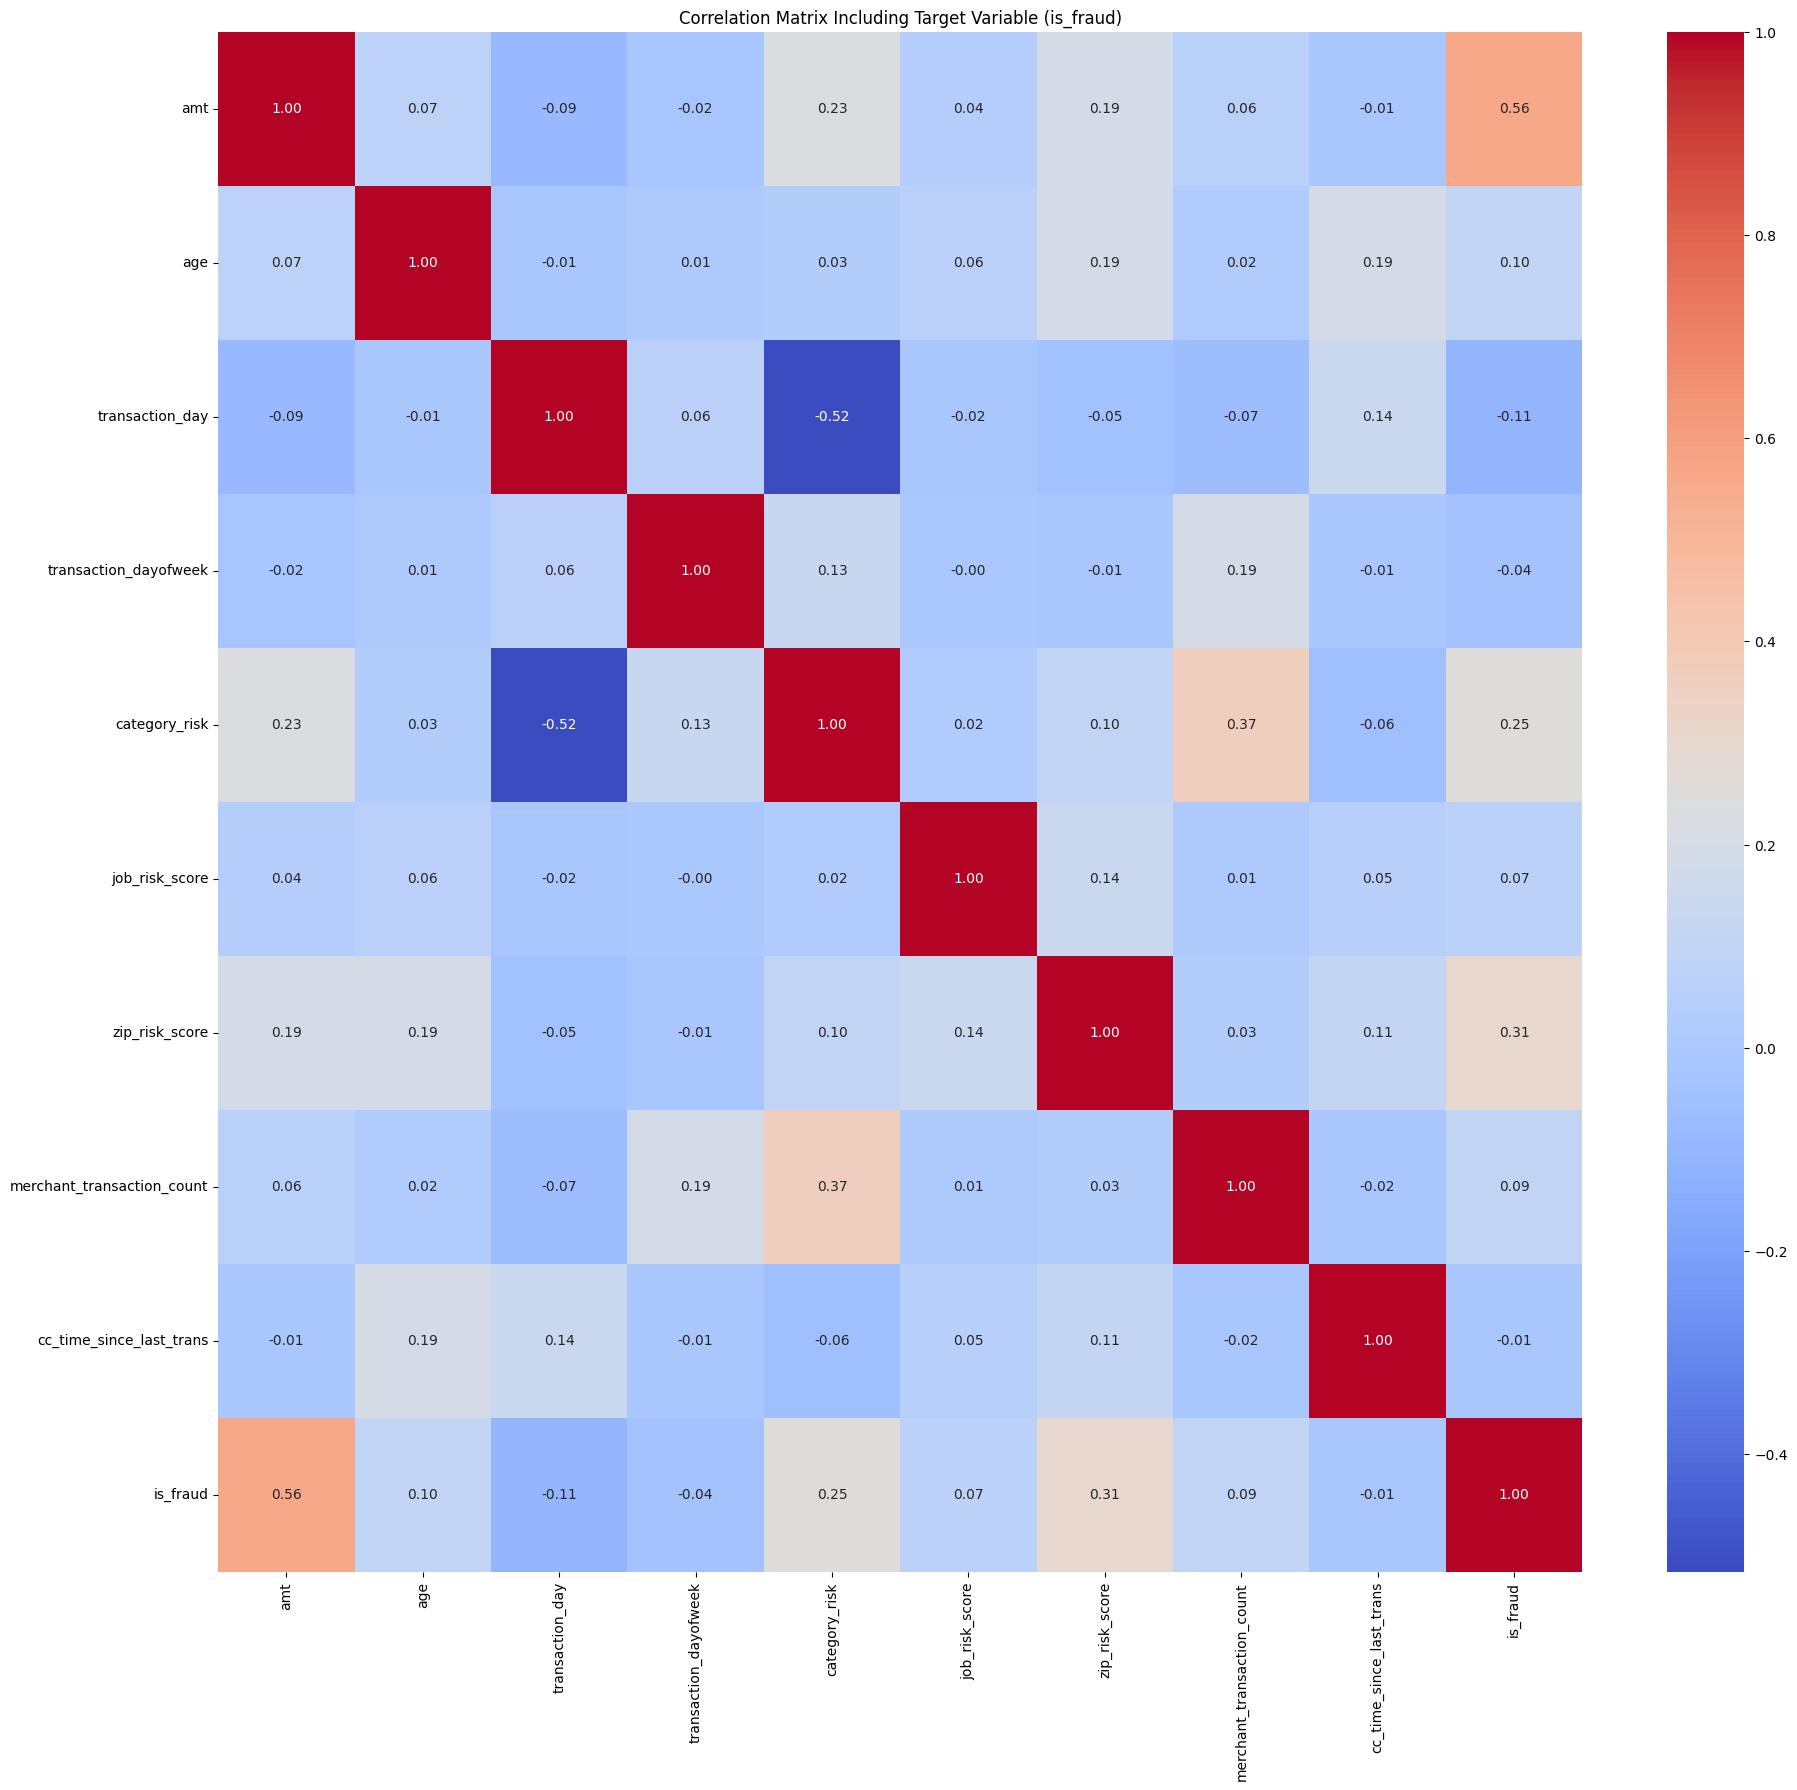

In [ ]:
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

selected_features = [
    'amt', 'age',
    'transaction_day', 'transaction_dayofweek', 
    'category_risk','job_risk_score','zip_risk_score','merchant_transaction_count','cc_time_since_last_trans'
] 

correlation_data = train_df[selected_features + ['is_fraud']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(22, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Including Target Variable (is_fraud)")
plt.show()

In [46]:
X = train_df[selected_features]
y = train_df['is_fraud']
X_test = test_df[selected_features]

In [47]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
lr_clf = LogisticRegression()
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_clf),
    ('rf', rf_clf),
    ('lr', lr_clf)
], voting='soft')

In [48]:
X_train_orig, X_valid_orig, y_train_orig, y_valid_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

xgb_clf.fit(X_train_orig, y_train_orig)
y_pred = xgb_clf.predict(X_valid_orig)

print("\nClassification Report on Validation Set:")
print(classification_report(y_valid_orig, y_pred))
print(f"F1 Score on Validation Set: {f1_score(y_valid_orig, y_pred)}")

c:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     65681
           1       0.97      0.94      0.96      8460

    accuracy                           0.99     74141
   macro avg       0.98      0.97      0.98     74141
weighted avg       0.99      0.99      0.99     74141

F1 Score on Validation Set: 0.9583283295304431


In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, classification_report

X = train_df[selected_features]
y = train_df['is_fraud']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_roc_auc = []
val_roc_auc = []
train_f1 = []
val_f1 = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    from xgboost import XGBClassifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    model.fit(X_train, y_train)
    
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_roc_auc.append(roc_auc_score(y_train, y_train_pred_proba))
    val_roc_auc.append(roc_auc_score(y_val, y_val_pred_proba))
    train_f1.append(f1_score(y_train, y_train_pred))
    val_f1.append(f1_score(y_val, y_val_pred))

print("ROC AUC Score:")
print(f"Train: {np.mean(train_roc_auc):.4f} ± {np.std(train_roc_auc):.4f}")
print(f"Validation: {np.mean(val_roc_auc):.4f} ± {np.std(val_roc_auc):.4f}")
print("\nF1 Score:")
print(f"Train: {np.mean(train_f1):.4f} ± {np.std(train_f1):.4f}")
print(f"Validation: {np.mean(val_f1):.4f} ± {np.std(val_f1):.4f}")

c:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

ROC AUC Score:
Train: 0.9990 ± 0.0000
Validation: 0.9981 ± 0.0001

F1 Score:
Train: 0.9671 ± 0.0005
Validation: 0.9571 ± 0.0007


In [50]:
# Predict on the test set
#test_preds = xgb_clf.predict(X_test)
test_preds = xgb_clf.predict(X_test)
submission = pd.DataFrame({'id': test_df['id'], 'is_fraud': test_preds})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created.")


Submission file 'submission.csv' created.
